In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [2]:
df = pd.read_excel('Thioesterase_Master_List.xlsx',sheet_name='characterized_TE',nrows=117)

In [3]:
file = pickle.load(open('TE_ML_Data_pickle.p','rb'))

In [4]:
enzyme_names,enzyme_class = file[0],file[2]

In [5]:
seq_df = df.loc[df.Species.isin(enzyme_names)]

In [6]:
enz_seq_dict = dict(zip(seq_df.Species.values,seq_df.Sequence.values))

In [7]:
enz_class_dict = dict(zip(enzyme_names,enzyme_class))

In [8]:
enz_seq_dict = {k:v.replace('-','') for k,v in enz_seq_dict.items()}

# These 3 enzymes do not have sequence data in the master list characterized_TE sheet

In [9]:
set(enzyme_names) - set(seq_df.Species)

{'UcFatB1_double(197M_R199H)',
 'UcFatB1_single(T231K)',
 'UcFatB1_triple(R197M_R199H_T231K)'}

# Forming a df with known enzyme sequence and class

In [10]:
enz_dict = {}

for e,seq in enz_seq_dict.items():
    enz_dict[e] = [seq,enz_class_dict[e]]

In [11]:
# with open('SVM/Data/Enzyme_Dataset.txt','w') as f:
#     for k,v in enz_dict.items():
#         f.write(k+','+v[0]+','+str(v[1]))
#         f.write('\n')

In [12]:
parsed_df = pd.DataFrame.from_dict(enz_dict,orient='index',columns=['Sequence','Class']).sort_index()

# Exploratory Data Analysis

## Dataset imbalance

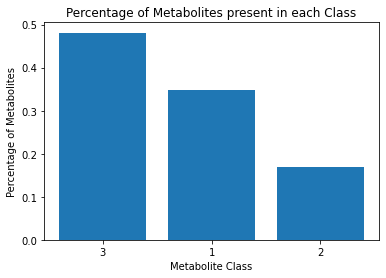

In [13]:
plt.bar(np.arange(len(np.unique(parsed_df.Class))),parsed_df.Class.value_counts(normalize=True).values)
plt.xticks(np.arange(len(np.unique(parsed_df.Class))),parsed_df.Class.value_counts().index)
plt.xlabel('Metabolite Class')
plt.ylabel('Percentage of Metabolites')
plt.title('Percentage of Metabolites present in each Class')
plt.savefig('Images/DatasetImbalance.png');

## Sequence Length

In [14]:
length_seq = np.array(list(map(len,parsed_df.Sequence.values)))

In [15]:
max(length_seq),np.mean(length_seq),np.std(length_seq)

(412, 363.77358490566036, 34.17250439987932)

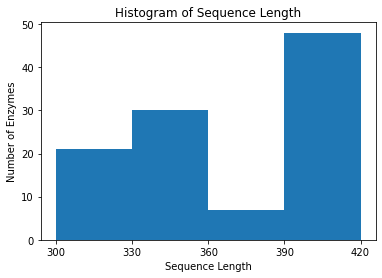

In [16]:
plt.hist(length_seq,bins=[300,330,360,390,420])
plt.xlabel('Sequence Length')
plt.ylabel('Number of Enzymes')
plt.title('Histogram of Sequence Length')
plt.xticks([300,330,360,390,420],[300,330,360,390,420]);

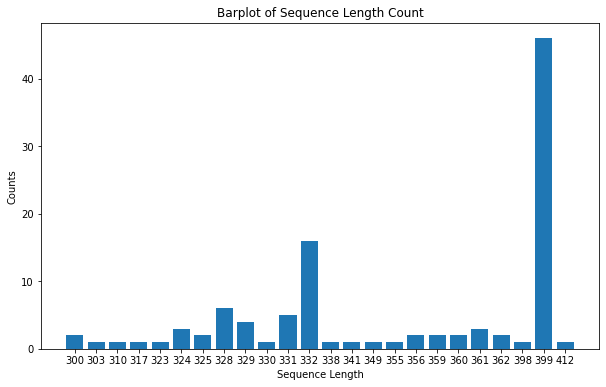

In [17]:
seq_length_count = np.unique(length_seq,return_counts=True)

plt.figure(figsize=(10,6))
plt.bar(np.arange(len(seq_length_count[0])),seq_length_count[1])
plt.xticks(np.arange(len(seq_length_count[0])),seq_length_count[0])
plt.title('Barplot of Sequence Length Count')
plt.xlabel('Sequence Length')
plt.ylabel('Counts')
plt.savefig('Images/SequenceLengthCount.png');

## Metabolite seq length divided into classes

In [18]:
parsed_df['Sequence_Length'] = parsed_df['Sequence'].apply(len)

In [19]:
gb = parsed_df.groupby('Class').Sequence_Length

### Class 1

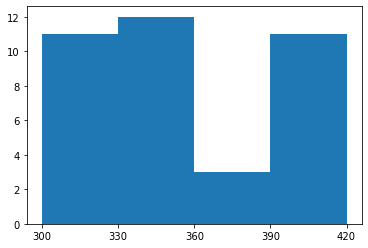

In [20]:
plt.hist(gb.get_group(1).values,bins=[300,330,360,390,420])
plt.xticks([300,330,360,390,420],[300,330,360,390,420]);

### Class 2

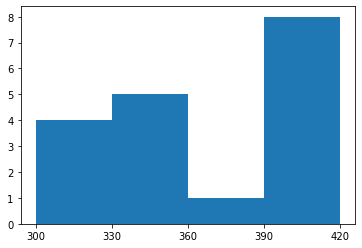

In [21]:
plt.hist(gb.get_group(2).values,bins=[300,330,360,390,420])
plt.xticks([300,330,360,390,420],[300,330,360,390,420]);

### Class 3

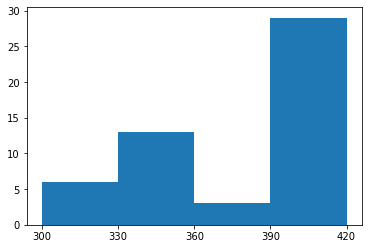

In [22]:
plt.hist(gb.get_group(3).values,bins=[300,330,360,390,420])
plt.xticks([300,330,360,390,420],[300,330,360,390,420]);

In [23]:
len(df.loc[df.Species.str.contains('Cuphea_viscosisssima')])

48

## Sequence Representation

### One-Hot Encoded

In [24]:
set_amino = set()
for seq in parsed_df.Sequence.values:
    for aa in seq:
        set_amino.add(aa)

AAs = np.array(list(set_amino)).reshape(-1,1)
onehotenc = OneHotEncoder().fit(AAs)

In [25]:
def get_OHE_seq(sequence):
    seq_array = np.array(list(sequence)).reshape(-1,1)
    return onehotenc.transform(seq_array).toarray().T

In [26]:
seq = parsed_df.Sequence.iloc[0]

In [27]:
get_OHE_seq(seq).shape

(21, 338)

In [28]:
def pad_OHE_seq(seq_arr):
    shape = seq_arr.shape
    add_shape = 420 - shape[1]
    
    if add_shape%2==0:
        ls = add_shape//2
        rs = add_shape//2
    else:
        ls = add_shape//2 + 1
        rs = add_shape//2
        
    ls_arr = np.zeros((shape[0],ls))
    rs_arr = np.zeros((shape[0],rs))
    
    ls_add = np.hstack((ls_arr,seq_arr))
    rs_add = np.hstack((ls_add,rs_arr))
    return rs_add

def get_seq(p_seq):
    return ''.join(onehotenc.inverse_transform(p_seq.T).flatten())

In [29]:
X_ohe = list(map(get_OHE_seq,parsed_df.Sequence.values))

In [30]:
X_p = list(map(pad_OHE_seq,X_ohe))

def ravel_helper(X_seq):
    return np.ravel(X_seq,'F')

X = np.array(list(map(ravel_helper,X_p)))

In [31]:
def pca(X_arr,components):
    pca = PCA(n_components=components)
    pca.fit(X_arr)
    X_pca_arr = pca.transform(X_arr)  
    return X_pca_arr

In [32]:
X_pca = pca(X,2)

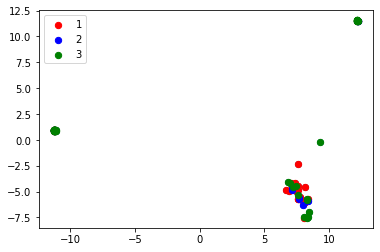

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

group = parsed_df.Class.values
cdict = {1:'red',2:'blue',3:'green'}

plt.scatter(X_pca[:,0],X_pca[:,1])

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_pca[:,0][ix], X_pca[:,1][ix], c = cdict[g], label = g, s = 40)
ax.legend()


In [34]:
def kmeans(X_arr):
    kmeans = KMeans(n_clusters=3,max_iter=1000,tol=1e-6,n_jobs=-1)
    kmeans.fit(X_arr)
    clusters = kmeans.predict(X_arr)
    return clusters
    
    

In [35]:
clusters = kmeans(X) + 1.5

/storage/home/dzb5732/.conda/envs/thio-env/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


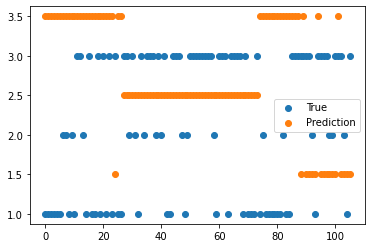

In [36]:
plt.scatter(np.arange(106),parsed_df.Class.values,label='True')
plt.scatter(np.arange(106),clusters,label='Prediction')
plt.legend();

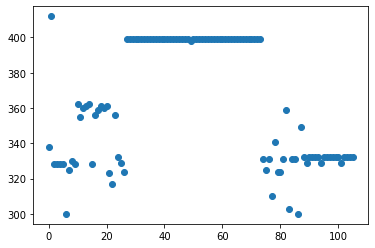

In [37]:
plt.scatter(np.arange(106),parsed_df.Sequence_Length)

**One-Hot Encoding is capturing the sequence length. We need a more meaningful representation of the features** 

In [38]:
def Ngram(*sequences,n=4):
    ngramdict = dict()
    
    for seq in sequences:
        i=0
        while i+n-1<len(seq):
            prev_word = seq[i:i+n-1]
            curr_word = seq[i+n-1]

            if prev_word in ngramdict:
                if curr_word in ngramdict[prev_word]:
                    ngramdict[prev_word][curr_word] += 1
                else:
                    ngramdict[prev_word][curr_word] = 1
            else:
                ngramdict[prev_word] = {curr_word:1}

            i+=1
    return ngramdict    

In [39]:
Seqs = list(parsed_df.Sequence.values)

## Ngram

### Ngramdict all sequences

In [40]:
mydict = Ngram(*Seqs,n=7)

In [41]:
mydict_prob = {}

for seq_prev,next_seq_dict in mydict.items():
    sum_vals = sum(next_seq_dict.values())
    prob_dict_next = {k:v/sum_vals for k,v in next_seq_dict.items()}
    mydict_prob[seq_prev] = prob_dict_next

In [42]:
# All possible representations

all_6_motifs = list(mydict_prob.keys())

### Ngramdict individual sequences

In [43]:
def Ngram_i(sequence,n=7):
    ngramdict = dict()

    i=0
    while i+n-1<len(sequence):
        prev_word = sequence[i:i+n-1]
        curr_word = sequence[i+n-1]

        if prev_word in ngramdict:
            if curr_word in ngramdict[prev_word]:
                ngramdict[prev_word][curr_word] += 1
            else:
                ngramdict[prev_word][curr_word] = 1
        else:
            ngramdict[prev_word] = {curr_word:1}

        i+=1
    return ngramdict    

In [44]:
individual_6_motifs = list(map(Ngram_i,Seqs))

In [45]:
# Need to convert them into a vector

def ngram_encoder_helper(seq6,seqv,v):
    fseq6 = np.ravel(get_OHE_seq(seq6),order='F')
    fseqv = np.ravel(get_OHE_seq(seqv),order='F')
    fv = np.array([v])
    return np.concatenate((fseq6,fseqv,fv))

def ngram_encoder(dictionary):
    encoded_list = []
    
    for seq_6,val_dict in dictionary.items():
        for k,v in val_dict.items():
            get_encoded_array = ngram_encoder_helper(seq_6,k,v)
            encoded_list.append(get_encoded_array)
    
    return np.concatenate(tuple(encoded_list))
        

In [46]:
encoded_ngrams = list(map(ngram_encoder,individual_6_motifs))

In [47]:
max_length = max(map(len,encoded_ngrams))

In [48]:
encoded_ngrams[0].shape

(49136,)

In [49]:
def pad_ngram(eng):
    diff = max_length - len(eng)
    
    if diff%2 == 0:
        ls = diff//2
        rs = diff//2
    else:
        ls = diff//2 + 1
        rs = diff//2
        
    return np.concatenate((np.zeros(ls),eng,np.zeros(rs)))    

In [50]:
padded_ngrams = list(map(pad_ngram,encoded_ngrams))

In [51]:
X_ng = np.array(padded_ngrams,ndmin=2)

## Bag of words

In [52]:
from collections import Counter

In [53]:
counterdicts = [Counter(s) for s in Seqs]

counter_probdicts = [{k:v/sum(cdict.values()) for k,v in cdict.items()} for cdict in counterdicts]

In [54]:
from collections import OrderedDict

In [55]:
m_dict = []

for cprobdict in counter_probdicts:
    for aa in AAs.flatten():
        if aa not in cprobdict:
            cprobdict[aa] = 0
    m_dict.append(OrderedDict(sorted(cprobdict.items())))

In [56]:
# Create a vector from m_dict

X_BoW = np.array([list(d.values()) for d in m_dict])

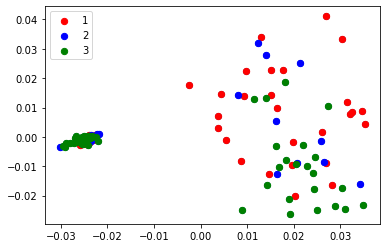

In [57]:
X_pca_bow = pca(X_BoW,2)

fig = plt.figure()
ax = fig.add_subplot(111)

group = parsed_df.Class.values
cdict = {1:'red',2:'blue',3:'green'}

plt.scatter(X_pca_bow[:,0],X_pca_bow[:,1])

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_pca_bow[:,0][ix], X_pca_bow[:,1][ix], c = cdict[g], label = g, s = 40)
ax.legend()

**THERE IS ABSOLUTELY NO/VERY LESS DIFFERENCE BETWEEN ENZYME SEQUENCES 27 to 73. AN ML MODEL WILL BE UNABLE TO CAPTURE ANY USEFUL INFORMATION FROM SUCH AN INPUT**

In [58]:
m_dict[-40],m_dict[-41]

(OrderedDict([('A', 0.06516290726817042),
              ('C', 0.007518796992481203),
              ('D', 0.06265664160401002),
              ('E', 0.06265664160401002),
              ('F', 0.03508771929824561),
              ('G', 0.07769423558897243),
              ('H', 0.015037593984962405),
              ('I', 0.042606516290726815),
              ('K', 0.06265664160401002),
              ('L', 0.09022556390977443),
              ('M', 0.03007518796992481),
              ('N', 0.045112781954887216),
              ('P', 0.06766917293233082),
              ('Q', 0.03007518796992481),
              ('R', 0.06265664160401002),
              ('S', 0.08521303258145363),
              ('T', 0.05764411027568922),
              ('V', 0.06015037593984962),
              ('W', 0.02506265664160401),
              ('X', 0),
              ('Y', 0.015037593984962405)]),
 OrderedDict([('A', 0.06516290726817042),
              ('C', 0.007518796992481203),
              ('D', 0.06265664160401002),
  

# 7-gram model motif builder

In [59]:
motif_builder = {k:v for k,v in mydict_prob.items() if len(v)>1}

In [60]:
all_motifs = sorted([k+k1 for k,v in motif_builder.items() for k1 in v.keys()])

In [61]:
len(all_motifs)

974

In [62]:
X_motif = []
for mydict in individual_6_motifs:
    ind_vector = np.zeros(len(all_motifs))
    ind_set = set([k+k1 for k,v in mydict.items() for k1 in v.keys()])
    for i in range(len(all_motifs)):
        if all_motifs[i] in ind_set:
            ind_vector[i] = 1
    X_motif.append(ind_vector)

In [63]:
X_motif = np.array(X_motif)

In [64]:
X_motif.shape

(106, 974)

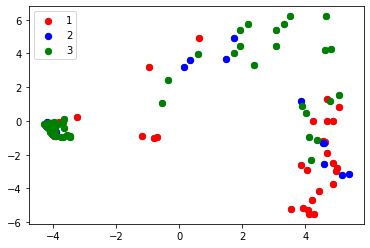

In [65]:
X_pca_motif = pca(X_motif,2)

fig = plt.figure()
ax = fig.add_subplot(111)

group = parsed_df.Class.values
cdict = {1:'red',2:'blue',3:'green'}

plt.scatter(X_pca_motif[:,0],X_pca_motif[:,1])

for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(X_pca_motif[:,0][ix], X_pca_motif[:,1][ix], c = cdict[g], label = g, s = 40)
ax.legend()

In [66]:
np.nonzero(X_motif[27] - X_motif[73])

(array([ 75, 652, 654, 941]),)

In [67]:
diff_val = [len(np.nonzero(X_motif[i]-X_motif[j])[0]) for i in range(27,73) for j in range(27,73)]

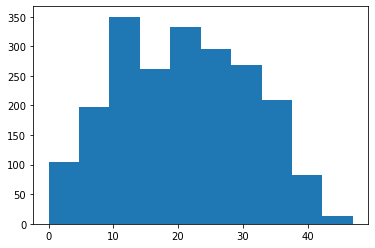

In [68]:
plt.hist(diff_val);

In [69]:
np.mean(diff_val)

20.858223062381853

In [70]:
X_motif.shape

(106, 974)

# SVM model

In [71]:
def get_classifier_score(X_arr,y_arr,c,k):
    X_train,X_test,y_train,y_test = train_test_split(X_arr,y_arr)
    pca = PCA(n_components=20)
    pca.fit(X_train)
    Xtrain = pca.transform(X_train)
    Xtest = pca.transform(X_test)
    clf = SVC(C = c,kernel=k,gamma='scale',tol=1e-6,class_weight='balanced')
    clf.fit(Xtrain,y_train)
    y_pred_train = clf.predict(Xtrain)
    y_pred_test = clf.predict(Xtest)
    return accuracy_score(y_train,y_pred_train),accuracy_score(y_test,y_pred_test)

In [72]:
scores = []

for i in range(10000):
    f1_sc = get_classifier_score(X_motif,parsed_df.Class.values,1.25,'rbf')
    scores.append(f1_sc)

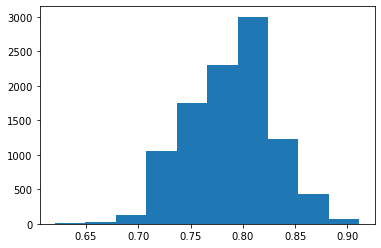

In [73]:
plt.hist([s[0] for s in scores]);

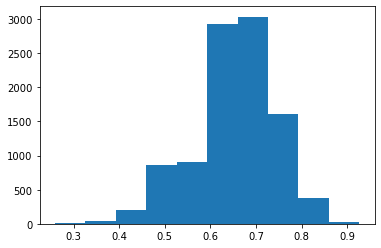

In [74]:
plt.hist([s[1] for s in scores]);